### Install and prepare necessary libraries

In [1]:
%pip install timm==1.0.3
%pip install wandb # I personally use wandb for results visualizations
!git clone https://github.com/Adamdad/rational_kat_cu.git
%cd rational_kat_cu
%pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'rational_kat_cu'...
remote: Enumerating objects: 2037, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 2037 (delta 75), reused 72 (delta 35), pack-reused 1917 (from 2)
Receiving objects: 100% (2037/2037), 275.76 KiB | 4.75 MiB/s, done.
Resolving deltas: 100% (1288/1288), done.
/kaggle/working/rational_kat_cu
Obtaining file:///kaggle/working/rational_kat_cu
  Preparing metadata (setup.py) ... done
  Running setup.py develop for kat_rational
Note: you may need to resta

In [2]:
!git clone https://github.com/Adamdad/kat.git

Cloning into 'kat'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 197 (delta 12), reused 13 (delta 5), pack-reused 171 (from 1)
Receiving objects: 100% (197/197), 1.71 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [3]:
%cd kat

/kaggle/working/rational_kat_cu/kat


In [4]:
%mv katransformer.py ..

In [5]:
%cd ..

/kaggle/working/rational_kat_cu


In [6]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 6.6 MB/s eta 0:00:000:00:0100:01


In [7]:
import os
import itertools
import torch
import timm
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# IMPORTANT: Import the module that registers your KAT models.
# This ensures that timm knows about 'kat_tiny_patch16_224'.
import katransformer

/kaggle/working/rational_kat_cu/kat_rational/rational_triton.py:244: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/kaggle/working/rational_kat_cu/kat_rational/rational_triton.py:273: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx: torch.autograd.Function, grad_output: Tensor):
/kaggle/working/rational_kat_cu/kat_rational/rational_triton2d.py:228: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/kaggle/working/rational_kat_cu/kat_rational/rational_triton2d.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cu

### Implement EarlyStopping Class 

In [8]:
class EarlyStopper:
    """
    Early stopping handler that saves model checkpoints and stops training when 
    validation loss stops improving.
    """
    def __init__(self, model, save_path: Path, patience: int, min_delta: float):
        """
        Args:
            model: The model being trained.
            save_path: Where to save the model checkpoint.
            patience: Number of epochs to wait before stopping.
            min_delta: Minimum change in loss to qualify as an improvement.
        """
        self.model = model
        self.save_path = save_path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)


    def save_checkpoint(self, model_state, validation_loss:float, epoch:int, optimizer_state=None):
        """
        Save checkpoint
        Args:
            model_state: The model we want to save
            validation_loss: Validation loss
            epoch: epoch we are in
            optimizer_state: The state of the optimizer (Optional)
        """
        checkpoint = {
            'model' : model_state,
            'epoch': epoch,
            'validation_loss': validation_loss
        }
        if optimizer_state is not None:
            checkpoint['optimizer_state_dict'] = optimizer_state

        torch.save(checkpoint, self.save_path)
        print(f'Checkpoint saved at epoch {epoch+1} to {self.save_path}')


    def early_stop(self, validation_loss:float, epoch=None, optimizer_state=None):
        """
        Check if training should stop and save checkpoint if loss improved.
        Returns True if training should stop.
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.save_checkpoint(self.model.state_dict(), validation_loss, epoch, optimizer_state)
            return False
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter +=1
            if self.counter >= self.patience:
                return True
        return False

### Train/Validate Epoch Functionality

In [9]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """
    Completes training for one epoch
    Args:
        model: The model to train
        train_loader: The train_dataset in PyTorch
        optimizer: The optimizer used (Adam)
        criterion: The criterion used (CrossEntropyLoss())
        device: The device the training takes place : CPU/GPU
    """
    model.train()
    total_loss = 0
    for x,y in train_loader:
        x , y = x.float().to(device) , y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [10]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Completes validation for one epoch
    Args:
        model: The model to train
        val_loader: The validation dataset in PyTorch
        optimizer: The optimizer used (Adam)
        criterion: The criterion used (CrossEntropyLoss())
        device: The device the training takes place : CPU/GPU
    """
    model.eval()
    total_loss = 0
    for x,y in val_loader:
        x , y = x.float().to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)

    return avg_loss

### Graph plotting

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.
    """
    if normalize:
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        row_sums[row_sums == 0] = 1
        cm = cm.astype('float') / row_sums
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right", fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=9)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/{title}.png')

def plot_training_history(history, title):
    """Plot training history including losses and learning rate.
    
    Args:
        history: Dictionary containing training history
    """

    # Plot losses
    plt.figure(figsize=(12, 8))
    plt.plot(history['train_loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True)
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/{}.png'.format(title))

### Model Training with EarlyStopping and Checkpoint Saving

In [12]:
def train_model(model, train_loader, val_loader, optimizer, criterion,
                epochs:int = 10, save_path: Path = Path("./"), device:str = 'cuda',
                title: str = "Training History"):
    """
    Train the model with early stopping and save the best checkpoint.
    Plot and save the confusion matrix along with the training and 
    validation loss graphs
    Args:
        model
        train_loader
        val_loader
        optimizer
        criterion
        epochs
        save_path: The path the model will be saved
        device
        title: The title of the training and validation loss graph of the model
    """
    history = {'train_loss': [], 'val_loss': []}
    early_stopper = EarlyStopper(model, save_path, patience=5, min_delta=0)

    for epoch in range(epochs):
        print(f"Training epoch {epoch+1}")
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )
        val_loss = validate_one_epoch(
            model, val_loader, criterion, device
        )

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}: Train Loss = {train_loss if train_loss is not None else "N/A"}, Val Loss = {val_loss if val_loss is not None else "N/A"}')

        if early_stopper.early_stop(val_loss, epoch, optimizer.state_dict()):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best model checkpoint
    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation loss: {checkpoint['validation_loss']:.4f}")
    
    plot_training_history(history, title=title)

    return model

### Evaluate Model on the Test Dataset

In [13]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def evaluate(model, val_loader, device, class_names=None):
    """
    Validate the model and print accuracy, classification report,
    and plot the confusion matrix.

    Args:
        model: The trained model.
        val_loader: DataLoader for the validation dataset.
        device: The device (e.g., 'cuda' or 'cpu').
        class_names: List of class names. If None, defaults to digits [0,1,...,9].

    Returns:
        accuracy: The overall accuracy on the validation set.
        y_pred: The predicted labels.
        y_true: The true labels.
    """
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.float().to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    if class_names is None:
        # Default class names for MNIST (digits 0-9)
        class_names = [str(i) for i in range(10)]

    plot_confusion_matrix(cm, classes=class_names, 
                          normalize=True, title='Confusion Matrix')

    return accuracy, y_pred, y_true

## Load pretrained model from HuggingFace

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Loading pretrained KAT model from Hugging Face...")
# Load the pretrained KAT-T (from ViT) model using the hf_hub identifier.
model = timm.create_model('hf_hub:adamdad/kat_tiny_patch16_224.vitft', pretrained=True)

Loading pretrained KAT model from Hugging Face...


config.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


### Reset classifier head and prepare model to be trained on multiple GPUs

In [16]:
import torch.nn as nn
model.reset_classifier(num_classes=10)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the adapted model to the device.
model = model.to(DEVICE)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training.")
    model = nn.DataParallel(model)

Using 2 GPUs for training.


### Finetune model on given dataset 

1. Tranform Images to Image-Net standards
2. Load the full training dataset
3. Split training dataset using stratification.
4. Separate model parameters into backbone and head groups.
5. Train Model
6. Evaluate Model on Test Set

In [17]:
def finetune_kan_generic(model, dataset_name: str, lr: float = 1e-5, 
                         batch_size: int = 32, epochs: int = 10, 
                         device: str = 'cuda', title: str = None, seed: int = 42):
    """
    Finetuning a pretrained KAT model on a specified dataset using ImageNet-style preprocessing.
    
    Args:
        model: The pretrained model for fine-tuning.
        dataset_name: Name of the dataset. Supported values: "MNIST", "FashionMNIST", "CIFAR10".
        lr: Base learning rate.
        batch_size: Batch size.
        epochs: Number of fine-tuning epochs.
        device: Device to run fine-tuning on.
        title: Title for logging/plots.
        seed: Random seed for reproducibility.
    
    Workflow:
      1. Set seeds for reproducibility.
      2. Define transforms:
            - Upscale images to 224x224,
            - For single-channel datasets (MNIST, FashionMNIST) convert to 3 channels,
            - Normalize using ImageNet statistics.
      3. Load the full training dataset using torchvision.datasets based on dataset_name.
      4. Use sklearn's train_test_split (with stratification) to split training data into 90% train and 10% validation.
      5. Create a test loader using the official test set.
      6. Separate model parameters into backbone and head groups.
      7. Train using train_model and evaluate on the test set.
    """
    # 1. Set seeds.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 2. Define transforms based on dataset.
    # All datasets are upscaled to 224x224.
    if dataset_name.lower() in ['mnist', 'fashionmnist']:
        # These are originally grayscale; convert to 3 channels.
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    elif dataset_name.lower() in ['cifar10', 'cifar100']:
        # CIFAR-10 is already RGB.
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    
    # 3. Load the full training dataset.
    if dataset_name.lower() == 'mnist':
        full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        targets = full_train_dataset.targets.numpy()  # targets as numpy array
    elif dataset_name.lower() == 'fashionmnist':
        full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        targets = full_train_dataset.targets.numpy()
    elif dataset_name.lower() == 'cifar10':
        full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        # CIFAR10 targets are in a list; convert to numpy array.
        targets = np.array(full_train_dataset.targets)
    elif dataset_name.lower() == 'cifar100':
        full_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
        targets = np.array(full_train_dataset.targets)
    
    # 4. Split training dataset using stratification.
    indices = np.arange(len(full_train_dataset))
    train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=seed, stratify=targets)
    
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # 5. Create a test loader.
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # 6. Separate model parameters into backbone and head groups.
    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "head" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)
    
    optimizer = optim.AdamW([
        {"params": backbone_params, "lr": lr/10},
        {"params": head_params, "lr": lr}
    ], weight_decay=1e-4)
    
    criterion = torch.nn.CrossEntropyLoss()

    # 7. Define checkpoint path.
    save_path = f"./checkpoints/transfer/kat_{dataset_name.upper()}_transfer_finetuned.pth"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # 8. Train the model.
    model = train_model(model, train_loader, val_loader, optimizer, criterion,
                        epochs, save_path, device, title=title)
    
    # 9. Evaluate on the test set.
    acc, preds, labels = evaluate(model, test_loader, device)
    print(f"Final test accuracy on {dataset_name.upper()}: {acc * 100:.2f}%")
    
    return model


In [ ]:
finetuned_model = finetune_kan_generic(model, lr = 3e-5,
                 batch_size = 64, epochs = 5, device = 'cuda',
                 title = 'KAT MNIST Finetuning')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 31.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 11.0MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.84MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training epoch 1


Epoch 1/5: Train Loss = 0.4635315980415756, Val Loss = 0.10607563966805948
Checkpoint saved at epoch 1 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.99MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training epoch 1


Epoch 1/10: Train Loss = 0.6636862997936694, Val Loss = 0.2852676253210991
Checkpoint saved at epoch 1 to ./checkpoints/transfer/kat_FASHIONMNIST_transfer_finetuned.pth
Training epoch 2
Epoch 2/10: Train Loss = 0.25679116663898194, Val Loss = 0.23085227283708593
Checkpoint saved at epoch 2 to ./checkpoints/transfer/kat_FASHIONMNIST_transfer_finetuned.pth
Training epoch 3
Epoch 3/10: Train Loss = 0.2093071750237196, Val Loss = 0.1954271081597247
Checkpoint saved at epoch 3 to ./checkpoints/transfer/kat_FASHIONMNIST_transfer_finetuned.pth
Training epoch 4
Epoch 4/10: Train Loss = 0.18119279534436797, Val Loss = 0.1873395951821449
Checkpoint saved at epoch 4 to ./checkpoints/transfer/kat_FASHIONMNIST_transfer_finetuned.pth
Training epoch 5
Epoch 5/10: Train Loss = 0.15923407587213928, Val Loss = 0.18303631254016084
Checkpoint saved at epoch 5 to ./checkpoints/transfer/kat_FASHIONMNIST_transfer_finetuned.pth
Training epoch 6
Epoch 6/10: Train Loss = 0.13999705919686933, Val Loss = 0.175967

<ipython-input-12-eb3e168ef660>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Accuracy: 0.9301
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.90      0.91      0.90      1000
           3       0.92      0.93      0.93      1000
           4       0.89      0.91      0.90      1000
           5       0.99      0.98      0.99      1000
           6       0.80      0.78      0.79      1000
           7       0.97      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Normalized confusion matrix
Final test accuracy on FASHIONMNIST: 93.01%


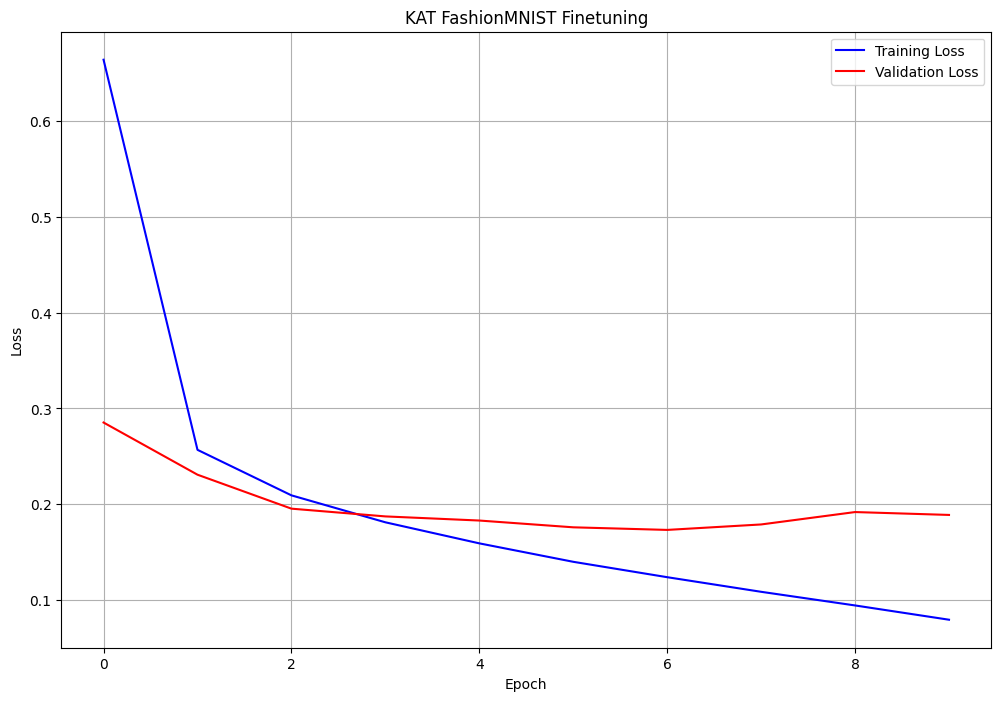

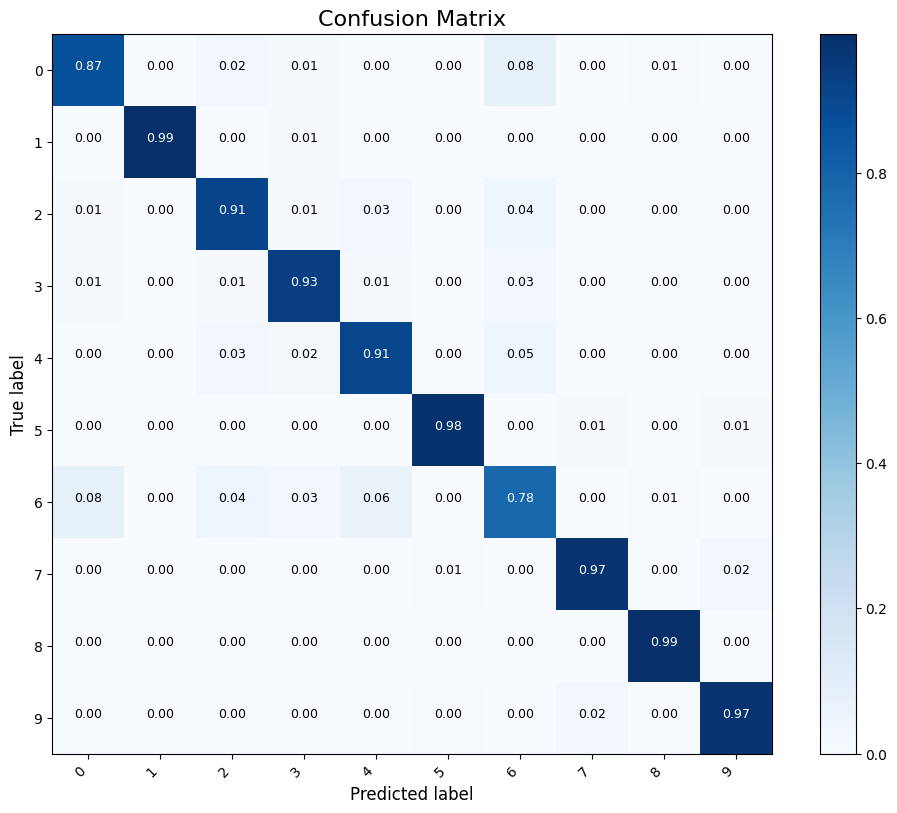

In [20]:
# Finetune on a chosen dataset: "MNIST", "FashionMNIST", or "CIFAR10"
finetuned_model = finetune_kan_generic(model, dataset_name="FashionMNIST", lr=5e-5, 
                                        batch_size=64, epochs=10,
                                        title='KAT FashionMNIST Finetuning', seed=42)

In [ ]:
# Finetune on a chosen dataset: "MNIST", "FashionMNIST", or "CIFAR10"
finetuned_model = finetune_kan_generic(model, dataset_name="CIFAR10", lr=5e-5, 
                                        batch_size=64, epochs=5, device='cuda',
                                        title='KAT CIFAR10 Finetuning', seed=42)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Loading pretrained KAT model from Hugging Face...")
# Load the pretrained KAT-T (from ViT) model using the hf_hub identifier.
model = timm.create_model('hf_hub:adamdad/kat_tiny_patch16_224.vitft', pretrained=True)

model.reset_classifier(num_classes=100)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the adapted model to the device.
model = model.to(DEVICE)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training.")
    model = nn.DataParallel(model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading pretrained KAT model from Hugging Face...
Using 2 GPUs for training.


/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Files already downloaded and verified
Files already downloaded and verified
Training epoch 1
Epoch 1/10: Train Loss = 0.26706865075340663, Val Loss = 0.6715374162679986
Checkpoint saved at epoch 1 to ./checkpoints/transfer/kat_CIFAR100_transfer_finetuned.pth
Training epoch 2
Epoch 2/10: Train Loss = 0.24402273025374266, Val Loss = 0.6736269517789913
Training epoch 3
Epoch 3/10: Train Loss = 0.22388582219454375, Val Loss = 0.677068291208412
Training epoch 4
Epoch 4/10: Train Loss = 0.2049519909884442, Val Loss = 0.6835402042805394
Training epoch 5
Epoch 5/10: Train Loss = 0.18705656183142724, Val Loss = 0.6953465078450456
Training epoch 6
Epoch 6/10: Train Loss = 0.17049784838772294, Val Loss = 0.7014895123016985
Early stopping triggered at epoch 6
Loaded best model from epoch 1 with validation loss: 0.6715


<ipython-input-12-eb3e168ef660>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Accuracy: 0.8057
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       100
           1       0.89      0.85      0.87       100
           2       0.76      0.71      0.73       100
           3       0.77      0.80      0.78       100
           4       0.58      0.67      0.62       100
           5       0.78      0.76      0.77       100
           6       0.94      0.90      0.92       100
           7       0.85      0.82      0.83       100
           8       0.97      0.91      0.94       100
           9       0.94      0.91      0.92       100
          10       0.67      0.70      0.69       100
          11       0.53      0.58      0.56       100
          12       0.86      0.79      0.82       100
          13       0.89      0.80      0.84       100
          14       0.85      0.84      0.84       100
          15       0.83      0.88      0.85       100
          16       0.84      0.86      0.

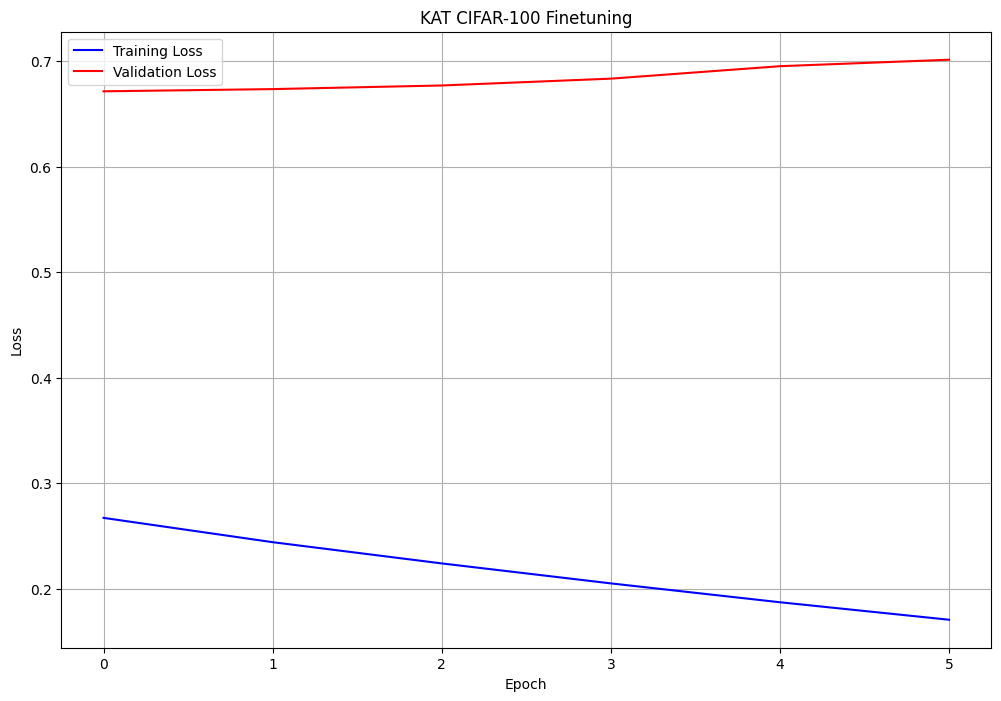

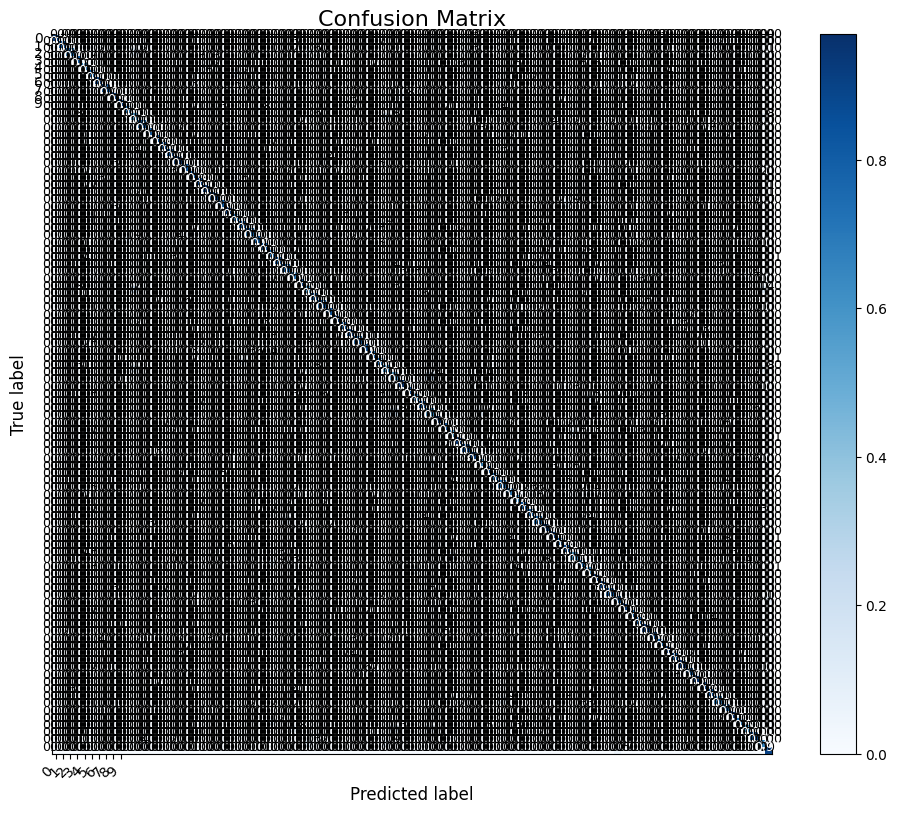

In [23]:
finetuned_model = finetune_kan_generic(model, dataset_name="CIFAR100", lr=2e-5,
                                        batch_size=64, epochs=10, device='cuda',
                                        title='KAT CIFAR-100 Finetuning', seed=42)

## Approach 2 (Adjust Model to MNIST Images)

In [43]:
import numpy as np
import torch
import random

def finetune_kan(model, lr: float = 1e-5, 
                 batch_size:int = 32, epochs:int = 10, device: str = 'cuda',
                 title:str = 'KAT MNIST Finetuning', seed:int =42):
    """
    Finetuning a Kan Model
    Args:
        model: The pretrained_model for finetuning
        lr: Learning rate
        batch_size: The batch size
        Epochs: Number of epochs for the finetuning process
        device: The device the finetuning takes place
        title: The title of the confusion matrix
    """
     # Set seeds for reproducibility.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior for cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Define transforms for MNIST: resize, convert grayscale to 3 channels, normalize.
    transform = transforms.Compose([
        transforms.Resize((28, 28)),                # Resize to 28x28 instead of 224x224
        transforms.Grayscale(num_output_channels=1),  # Single channel for MNIST
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Load the MNIST datasets.
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset   = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Separate parameters into backbone and head so that they do not overlap.
    backbone_params = []
    head_params = []
    for name,param in model.named_parameters():
        if "head" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": lr/10},
        {"params": head_params, "lr": lr}
    ], weight_decay=1e-4)

    criterion = torch.nn.CrossEntropyLoss()

    # Define the checkpoint path for early stopping.
    save_path = "./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    
    # Train the model using the training utilities.
    model = train_model(model, train_loader, val_loader, optimizer, criterion,
                epochs, save_path, device, title=title)

    acc, preds, labels = evaluate(model, val_loader, device)

    print(f"Final validation accuracy: {acc * 100:.2f}%")
    return model

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Loading pretrained KAT model from Hugging Face...")
# Load the pretrained KAT-T (from ViT) model using the hf_hub identifier.
model = timm.create_model('hf_hub:adamdad/kat_tiny_patch16_224.vitft', pretrained=True)

Loading pretrained KAT model from Hugging Face...


In [45]:
# Step 2: Replace the patch embedding layer.
# Create a new patch embedding layer for MNIST images:
# - img_size=28 (MNIST images are 28x28)
# - patch_size=4 (so you'll get (28/4)^2 = 49 patches)
# - in_chans=1 (MNIST is grayscale)
from timm.models.layers import PatchEmbed, trunc_normal_
from torch import nn
# - embed_dim remains the same as the original model (pretrained weights in later layers can be reused)
new_patch_embed = PatchEmbed(img_size=28, patch_size=4, in_chans=1, embed_dim=model.embed_dim)
model.patch_embed = new_patch_embed

In [46]:

# Step 3: Reinitialize the positional embeddings.
# The original model's pos_embed was sized for (224/16)^2 (+1 token if class token exists),
# so we need a new positional embedding for our new number of patches.
if model.pos_embed is not None:
    num_tokens = new_patch_embed.num_patches + (1 if getattr(model, 'has_class_token', False) else 0)
    new_pos_embed = torch.zeros(1, num_tokens, model.embed_dim)
    trunc_normal_(new_pos_embed, std=0.02)
    model.pos_embed = nn.Parameter(new_pos_embed)


In [47]:
# Step 4: Reset the classifier head for 10 classes.
model.reset_classifier(num_classes=10)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the adapted model to the device.
model = model.to(DEVICE)

Training epoch 1
Epoch 1/10: Train Loss = 1.5271139342625937, Val Loss = 1.1555286430703184
Checkpoint saved at epoch 0 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 2
Epoch 2/10: Train Loss = 1.0360524783611298, Val Loss = 0.9533507018424452
Checkpoint saved at epoch 1 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 3
Epoch 3/10: Train Loss = 0.8549800486882527, Val Loss = 0.7836842162730976
Checkpoint saved at epoch 2 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 4
Epoch 4/10: Train Loss = 0.7313820361932118, Val Loss = 0.7274638319167847
Checkpoint saved at epoch 3 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 5
Epoch 5/10: Train Loss = 0.630280574409167, Val Loss = 0.6580126081792691
Checkpoint saved at epoch 4 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 6
Epoch 6/10: Train Loss = 0.5431900662024816, Val Loss = 0.5486684937399036
Checkpoint sav

<ipython-input-18-eb3e168ef660>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Checkpoint saved at epoch 9 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Loaded best model from epoch 10 with validation loss: 0.4091
Accuracy: 0.8658
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       980
           1       0.98      0.98      0.98      1135
           2       0.85      0.75      0.80      1032
           3       0.87      0.72      0.79      1010
           4       0.89      0.93      0.91       982
           5       0.64      0.92      0.76       892
           6       0.93      0.90      0.92       958
           7       0.89      0.89      0.89      1028
           8       0.85      0.83      0.84       974
           9       0.90      0.82      0.86      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.88      0.87      0.87     10000



NameError: name 'confusion_matrix' is not defined

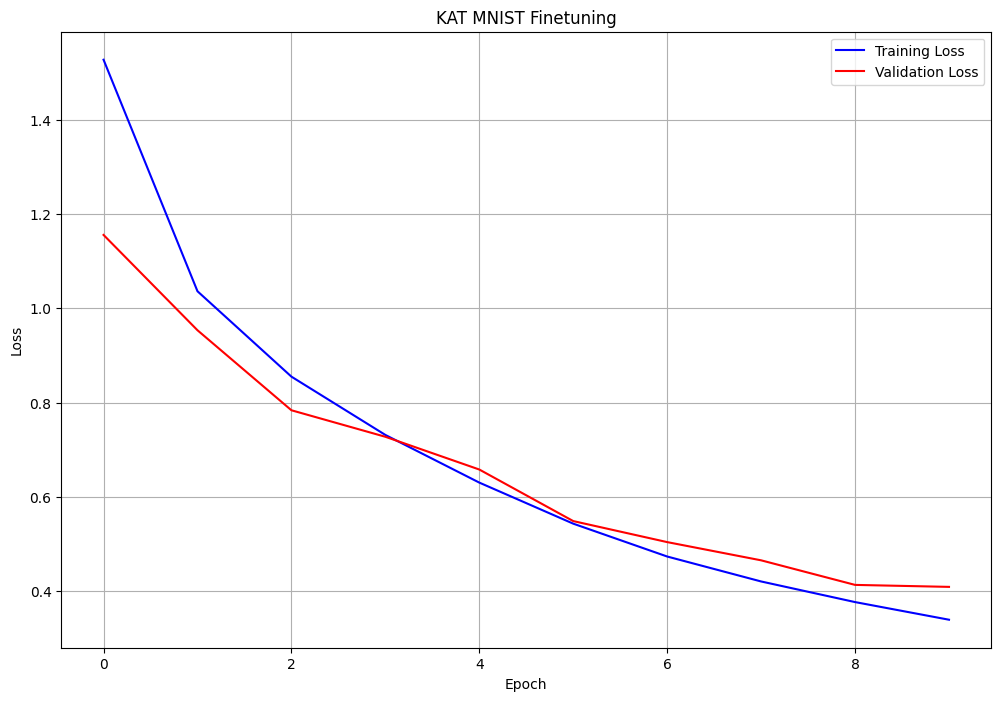

In [48]:
finetuned_model = finetune_kan(model, lr = 3e-5,
                 batch_size = 32, epochs = 20, device = 'cuda',
                 title = 'KAT MNIST Finetuning')

We can see that the 2nd approach leads to pretrained information loss, since we change the patch embedding layer. 
This adjustment causes our model to need more epochs to learn and it seems that the KAT model doesnt retain in
the same grade as the 1st approach the "knowledge" of the pretrained model.